## Class Separability Analysis

Epoch 1/3
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5509 - loss: 1.2291 - val_accuracy: 0.6544 - val_loss: 1.0211
Epoch 2/3
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6155 - loss: 1.0375 - val_accuracy: 0.6512 - val_loss: 1.0140
Epoch 3/3
475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6462 - loss: 0.9915 - val_accuracy: 0.6554 - val_loss: 0.9881
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


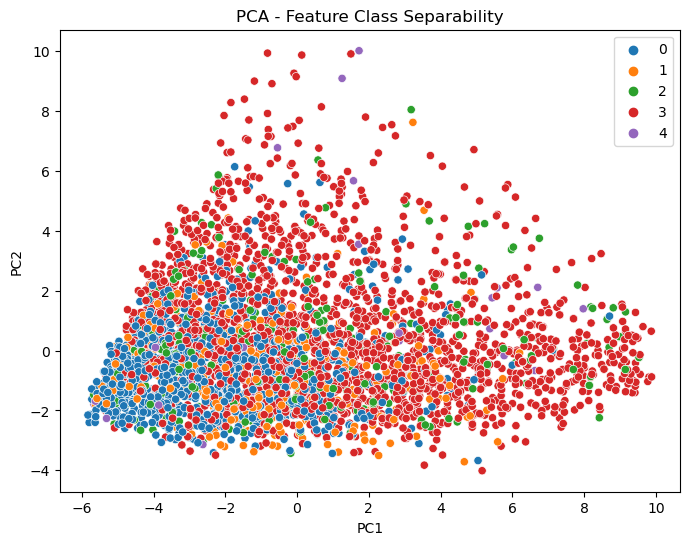

Silhouette Score: -0.0562


In [43]:
# Imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Functional API model (solves all .input issues)
input_layer = Input(shape=X_train.shape[1:])
x = Flatten()(input_layer)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32)

# Extract penultimate features
penultimate_model = Model(inputs=model.input, outputs=model.layers[-2].output)
X_features = penultimate_model.predict(X_test)
y_labels = np.argmax(y_test, axis=1)

# PCA and plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='tab10')
plt.title("PCA - Feature Class Separability")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Silhouette score
score = silhouette_score(X_pca, y_labels)
print(f"Silhouette Score: {score:.4f}")


## LIME for Local Interpretability

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━

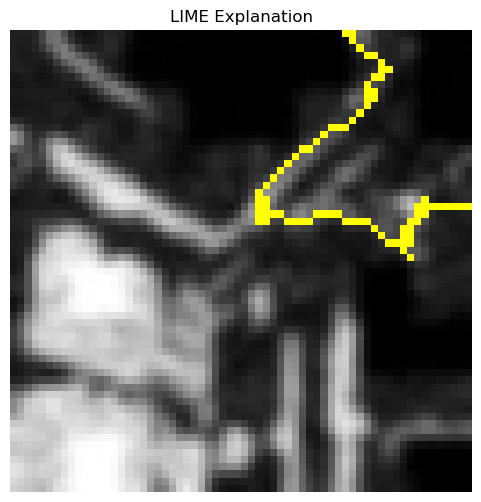

In [44]:
# Install lime if needed
!pip install -q lime

import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Define a flexible prediction function for LIME
def predict_fn(images):
    images = images.astype('float32') / 255.0  # normalize to match model input

    # Handle flattened models (e.g., input_shape = (4096,))
    if len(model.input_shape) == 2 and model.input_shape[1] == np.prod(images.shape[1:]):
        images = images.reshape((images.shape[0], -1))

    # Handle grayscale models (e.g., input_shape = (64, 64, 1))
    elif model.input_shape[-1] == 1:
        images = np.mean(images, axis=-1, keepdims=True)

    return model.predict(images)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Choose one image from X_test
idx = 0
image = X_test[idx]

# Ensure 3-channel (RGB) format
if image.ndim == 2:
    image = np.stack([image] * 3, axis=-1)
elif image.shape[-1] == 1:
    image = np.concatenate([image] * 3, axis=-1)
elif image.shape[-1] != 3:
    raise ValueError(f"Unsupported image shape: {image.shape}")

# Convert image to uint8 in case it's normalized
if image.max() <= 1.0:
    image = (image * 255).astype('uint8')
else:
    image = image.astype('uint8')

# Explain the prediction
explanation = explainer.explain_instance(
    image=image,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Visualize the LIME explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


## Model Performance Evaluation

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Labels in y_test:      [0 1 2 3 4]
Labels predicted:      [0 1 2 3]
              precision    recall  f1-score   support

           0       0.54      0.71      0.61      1056
           1       0.49      0.12      0.19       348
           2       0.75      0.06      0.11       304
           3       0.73      0.82      0.77      2054
           4       0.00      0.00      0.00        31

    accuracy                           0.66      3793
   macro avg       0.50      0.34      0.34      3793
weighted avg       0.65      0.66      0.61      3793



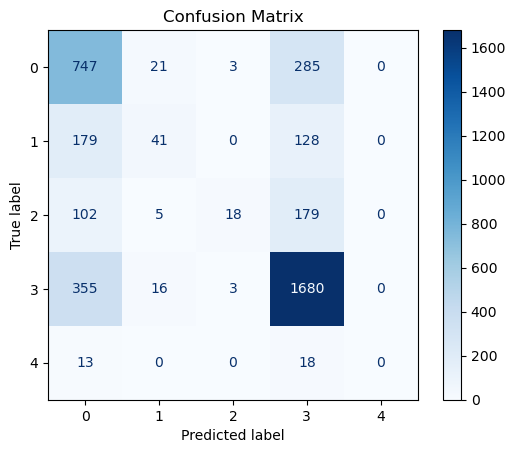

In [45]:
# --- Model Performance Evaluation (Fixed) ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Show what labels were predicted
print("Labels in y_test:     ", np.unique(y_true))
print("Labels predicted:     ", np.unique(y_pred))

# Classification report with safe fallback
print(classification_report(y_true, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Empirical Tuning Round 1

In [46]:
# --- Empirical Tuning Round 1 (Fixed) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Split X_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Get input shape from training data
input_shape = X_train.shape[1:]  # e.g., (64, 64, 3)

# Define model
model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # number of classes
])

# Compile with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10


C:\Users\GINE\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5535 - loss: 1.2436 - val_accuracy: 0.6079 - val_loss: 1.0694
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6162 - loss: 1.0443 - val_accuracy: 0.6132 - val_loss: 1.0626
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6350 - loss: 0.9979 - val_accuracy: 0.6155 - val_loss: 1.0743
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6441 - loss: 0.9817 - val_accuracy: 0.6498 - val_loss: 0.9988
Epoch 5/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6399 - loss: 0.9898 - val_accuracy: 0.6191 - val_loss: 1.0258
Epoch 6/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6487 - loss: 0.9613 - val_accuracy: 0.6056 - val_loss: 1.0447
Epoch 7/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6606 - loss: 0.9497 - val_accuracy: 0.6181 - val_loss: 1.0314
Epoch 8/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6662 - loss: 0.9353 - val_accuracy: 0.6158 - val_

## Empirical Tuning Round 2

In [47]:
# --- Empirical Tuning Round 2 ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Resplit training and validation sets (optional, or reuse previous split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Get input shape from training data
input_shape = X_train.shape[1:]

# Define modified model (deeper, with extra Dropout)
model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.4),                      # Increased dropout
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile with slightly lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5217 - loss: 1.2435 - val_accuracy: 0.6199 - val_loss: 1.0738
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6076 - loss: 1.0689 - val_accuracy: 0.6479 - val_loss: 1.0222
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6140 - loss: 1.0456 - val_accuracy: 0.6450 - val_loss: 0.9929
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6276 - loss: 1.0089 - val_accuracy: 0.6479 - val_loss: 1.0048
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6406 - loss: 0.9937 - val_accuracy: 0.5420 - val_loss: 1.0838
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6415 - loss: 0.9840 - val_accuracy: 0.6256 - val_loss: 1.0208
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6517 - loss: 0.9632 - val_accuracy: 0.5815 - val_loss: 1.0523
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6527 - loss: 0.9723 - val_acc

## 🔁 Empirical Tuning Round 3

In [48]:
# --- Empirical Tuning Round 3 ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Resplit training and validation sets (optional, or reuse previous split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Get input shape from training data
input_shape = X_train.shape[1:]

# Define modified model (same depth as Round 2)
model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile with SGD optimizer and momentum
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Setup EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5637 - loss: 1.1758 - val_accuracy: 0.6444 - val_loss: 1.0684
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6313 - loss: 1.0393 - val_accuracy: 0.6001 - val_loss: 1.0599
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6176 - loss: 1.0513 - val_accuracy: 0.6104 - val_loss: 1.0322
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6364 - loss: 0.9990 - val_accuracy: 0.6511 - val_loss: 1.0095
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6429 - loss: 0.9899 - val_accuracy: 0.5054 - val_loss: 1.1296
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6502 - loss: 0.9794 - val_accuracy: 0.5358 - val_loss: 1.1013
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6455 - loss: 0.9744 - val_accuracy: 0.6294 - val_loss: 1.0060
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6446 - loss: 0.9706 - val_accuracy: 0